## Human Activity Recognition from accelerometer data

Note: Settling to use Conv1D Deep Neural Net architecture and diving in further

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
from keras import regularizers

#required to remove a weird error probably due to OSX version:
#OMP: Error #15: Initializing libiomp5.dylib, but found libomp.dylib already initialized.
#http://support.genarts.com/knowledgebase/article/View/1365/339/why-am-i-getting-this-error-omp-error-15-initializing-libiomp5so-but-found-libguideso-already-initialized
#https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
import lightgbm as lgb

/anaconda2/envs/activity_recognition/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
datafolder='Activity_Recognition_from Single_Chest-Mounted_Accelerometer/'
person={}
for i in range(15):
    person[i+1]= pd.read_csv(datafolder+str(i+1)+'.csv',index_col=0,names=['seq num', 'ax', 'ay', 'az', 'label']) 

In [6]:
#Check data shapes
for i in person: print(i,'shape:',person[i].shape)#,'columns:',person[i].columns)

1 shape: (162501, 4)
2 shape: (138001, 4)
3 shape: (102341, 4)
4 shape: (122201, 4)
5 shape: (160001, 4)
6 shape: (140901, 4)
7 shape: (163001, 4)
8 shape: (138001, 4)
9 shape: (166741, 4)
10 shape: (126801, 4)
11 shape: (104451, 4)
12 shape: (114702, 4)
13 shape: (67651, 4)
14 shape: (116101, 4)
15 shape: (103501, 4)


In [7]:
class_dict={}
class_dict[1]='Working at Computer'
class_dict[2]='Standing Up, Walking and Going Up/Down stairs' 
class_dict[3]='Standing'
class_dict[4]='Walking'
class_dict[5]='Going Up/Down Stairs'
class_dict[6]='Walking and Talking with Someone'
class_dict[7]='Talking while Standing'

In [8]:
#after 100000 the time step does not increment by 1? but maybe its ok.
#person[1].iloc[99997:100003]

In [9]:
def plot_data(folder='raw',save=False):
    os.system('mkdir -p plots/'+folder)
    for i in person:

        fig, ax = plt.subplots(4,1, figsize=(6.4*1.5,4.8*1.5),sharex='col') 

        ax[0].plot(person[i]['ax'])
        ax[0].set_ylabel('ax')

        ax[1].plot(person[i]['ay'])
        ax[1].set_ylabel('ay')

        ax[2].plot(person[i]['az'])
        ax[2].set_ylabel('az')

        ax[3].plot(person[i]['label'])
        ax[3].set_ylabel('label')

        fig.suptitle('person '+str(i))

        if(save):fig.savefig('plots/'+folder+'/'+'person'+str(i))
        
        
def normalize_data(dataset):
    dataset = dataset - dataset.mean()
    dataset = dataset/dataset.std()
    return dataset


def get_data_per_class_per_person():
    #separate data into classes 
    #act := act[class type][person number]
    act = {}
    for i in range(1,8):
        act[i] = {}
        for j in person:
            act[i][j] = person[j][person[j]['label']==i]

    return act


def plot_per_class_per_person(act,save=False):
    folder = 'separate_class'
    os.system('mkdir -pv plots/'+folder)
    for c in range(1,8):

        for i in person:

            fig, ax = plt.subplots(3,1, figsize=(6.4*2,4.8*1.5),sharex='col') 

            ax[0].plot(act[c][i]['ax'],'.')
            ax[0].set_ylabel('ax')

            ax[1].plot(act[c][i]['ay'],'.')
            ax[1].set_ylabel('ay')

            ax[2].plot(act[c][i]['az'],'.')
            ax[2].set_ylabel('az')

            fig.suptitle('person '+str(i)+': '+class_dict[c])

            if(save):fig.savefig('plots/'+folder+'/'+'act_'+str(c)+'_person '+str(i))

            if i > 3:
                fig.clf()


# Remove entries with label=0
def remove_0_labels():
    for i in person:
        index_to_drop = person[i][person[i]['label']==0].index
        person[i] = person[i].drop(index_to_drop)

        
# normalize data
def normalize_all_data():
    for i in person: 
        for col in ['ax','ay','az']:
            person[i][col] = normalize_data(person[i][col])

In [10]:
#clean up NaN
def fillna_with_zeros():
    for p in person:
        person[p].fillna(0)

In [11]:
#probably some kind of low pass filtering would be usefu. To do.
def lowpassfilter(dataset):
    pass

In [12]:
###FEATURE ENGINEERING

def add_features(window=52 * 3):

    print('using window of',window)

    #Add rolling mean
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_MA'+str(window)] = person[i][col].rolling(window).mean()

    #Add rolling std
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_stdA'+str(window)] = person[i][col].rolling(window).std()

    #Add rolling sum
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_sumA'+str(window)] = person[i][col].rolling(window).sum()

    #Add rolling max
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_maxA'+str(window)] = person[i][col].rolling(window).max()

    #Add rolling min
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_minA'+str(window)] = person[i][col].rolling(window).min()

    #Add rolling median
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_medA'+str(window)] = person[i][col].rolling(window).median()

    #Add rolling covariance
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_covA'+str(window)] = person[i][col].rolling(window).cov()

    #Add rolling kurtosis
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_kurtA'+str(window)] = person[i][col].rolling(window).kurt()

    #Add rolling skew
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_skewA'+str(window)] = person[i][col].rolling(window).skew()    

    #Add magnitude of total acc vector sqrt(ax^2+ay^2+az^2)
    for i in person:
        person[i]['mag_a'] = np.sqrt (person[i]['ax']**2 + person[i]['ay']**2 + person[i]['az']**2)

    #Add rolling mean of magnitude of total acc 
    for i in person:
        person[i]['mag_a_MA'] = person[i]['mag_a'].rolling(window).mean()

    #Add rolling sum of magnitude of total acc 
    for i in person:
        person[i]['mag_a_MA'] = person[i]['mag_a'].rolling(window).sum()

    #Add rolling std of magnitude of total acc 
    for i in person:
        person[i]['mag_a_MA'] = person[i]['mag_a'].rolling(window).std()

    #Add angle
    for i in person:
        for col in ['ax','ay','az']:
            person[i]['phi_'+col] = np.arccos( person[i][col] / person[i]['mag_a'] )   

    #Add difference between time steps 
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_diff'] = person[i][col].diff()

    #Add rolling mean of difference between time steps 
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_diff_MA'] = person[i][col+'_diff'].rolling(window).mean()

def dropFeatures():
    for i in person:
        person[p] = person[['ax','ay','az','label']]

Lets plot the raw data

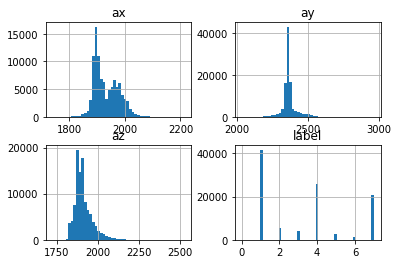

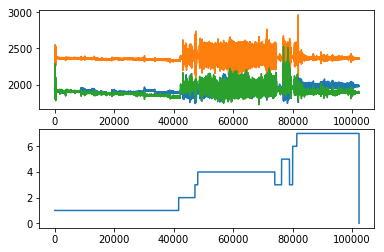

In [13]:
# plot_data('raw')
fig,ax = person[3].hist(bins=50)
fig2,ax2 = plt.subplots(2,1)
ax2[0].plot(person[3].drop(columns='label'))
ax2[1].plot(person[3]['label'])

There are entries with invalid class=0. Lets remove them.

In [14]:
#person[2][person[2]['label']==0].head()
remove_0_labels()
normalize_all_data()

Lets see what the data looks like after normalizing

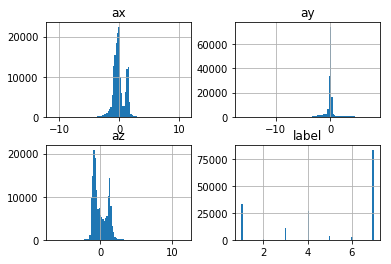

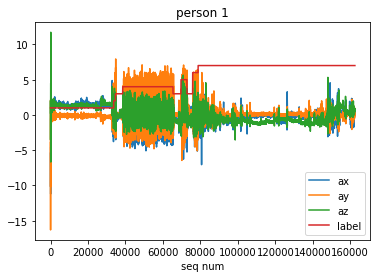

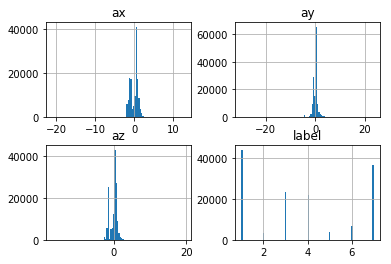

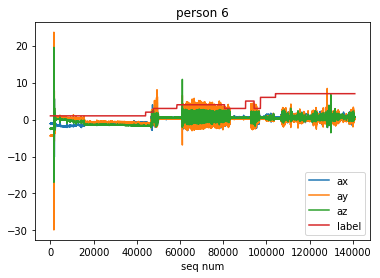

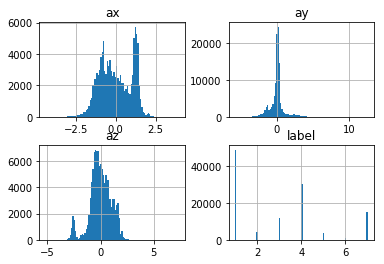

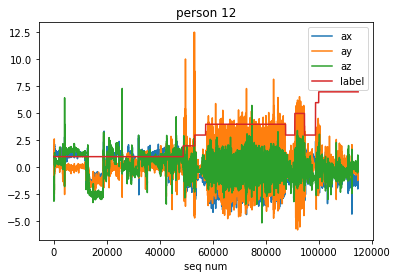

In [15]:
for p in [1,6,12]:
    person[p].hist(bins=100)
    person[p].plot(title='person {}'.format(p))

ax and az consistently have a larger spread compared to ay. ay is likely be the vertical axis.

In [16]:
ax,ay,az = pd.Series(),pd.Series(),pd.Series()
for p in person:
    ax = ax.append(person[p]['ax'])
    ay = ay.append(person[p]['ay'])
    az = az.append(person[p]['az'])

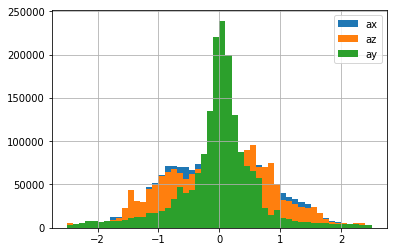

In [17]:
ax.hist(bins=50,range=[-2.5,2.5],label='ax')
az.hist(bins=50,range=[-2.5,2.5],label='az')
ay.hist(bins=50,range=[-2.5,2.5],label='ay')
plt.legend()

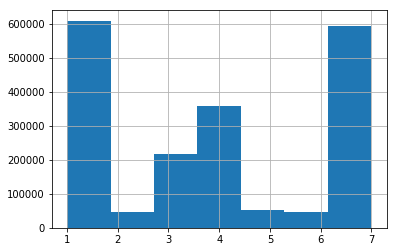

In [18]:
labels = pd.Series()
for p in person:
    labels = labels.append(person[p]['label'])
labels.hist(bins=7)

Labels are mostly 1,4,7 we expect the model will probably learn mostly these activities.

In [19]:
#rolling window of 3 sec
add_features(52*3) 
fillna_with_zeros()

# save_preprocess_3d_np(person,'data_norm_3d_np_withFeatures')

using window of 156


In [54]:
#check added features:
print(person[p].columns)
print('Total number of features',len(person[p].columns)-1)

Index(['ax', 'ay', 'az', 'label', 'ax_MA156', 'ay_MA156', 'az_MA156',
       'ax_stdA156', 'ay_stdA156', 'az_stdA156', 'ax_sumA156', 'ay_sumA156',
       'az_sumA156', 'ax_maxA156', 'ay_maxA156', 'az_maxA156', 'ax_minA156',
       'ay_minA156', 'az_minA156', 'ax_medA156', 'ay_medA156', 'az_medA156',
       'ax_covA156', 'ay_covA156', 'az_covA156', 'ax_kurtA156', 'ay_kurtA156',
       'az_kurtA156', 'ax_skewA156', 'ay_skewA156', 'az_skewA156', 'mag_a',
       'mag_a_MA', 'phi_ax', 'phi_ay', 'phi_az', 'ax_diff', 'ay_diff',
       'az_diff', 'ax_diff_MA', 'ay_diff_MA', 'az_diff_MA'],
      dtype='object')
Total number of features 41


## Boosted Decision Tree

Using the person 13 as validation. Holding out person 1,2 for test set. The rest for training. 

In [21]:
# Train val test split for LightGBM. Not really kFolding. Naming is misnomer.

kFold_num = 1

#define the KFolding
kFold_tr = {}
kFold_val = {}

kFold_val[0]= [13]
# kFold_val[1]= ?
# kFold_val[2]= ?

kFold_train=[3,4,5,6,7,8,9,10,11,12,14,15] #hold out 1,2 for test.
kFold_test=[1,2]

for i in range(kFold_num):
    set_all = set(kFold_train)
    set_val = set(kFold_val[i])
    kFold_tr[i]=list(set_all-set_val)
    print ('\n kFold '+str(i+1)+', val:'+str(kFold_val[i])+', tr: '+str(kFold_tr[i]))


train = {}
val = {}
x_tr = {}
y_tr = {}
x_val = {}
y_val = {}
for i in range(kFold_num):

    train[i] = pd.DataFrame()
    val[i] = pd.DataFrame()
    for j in kFold_tr[i]:
        train[i] = train[i].append(person[j])

    for j in kFold_val[i]:
        val[i] = val[i].append(person[j])

    #define x and y
    x_tr[i] = train[i].drop(columns='label')
    y_tr[i] = train[i]['label']
    
    #drop label
    x_val[i] = val[i].drop(columns='label')
    y_val[i] = val[i]['label']

    #clean up
    x_tr[i] = x_tr[i].fillna(0)
    x_val[i] = x_val[i].fillna(0)


 kFold 1, val:[13], tr: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]


Lets Check the distribution on labels for the train set just to make sure no labels are missing

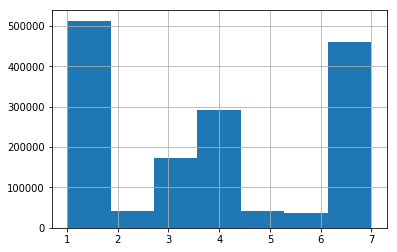

In [22]:
train_labels = pd.Series()
for p in kFold_train:
    train_labels = train_labels.append(person[p]['label'])
train_labels.hist(bins=7)

In [23]:
#test set
test = pd.DataFrame()
for i in kFold_test:
    test = test.append(person[i])

#drop label
x_test = test.drop(columns='label')
y_test = test['label']

#clean up
x_test = x_test.fillna(0)

In [24]:
evals_result = {}
lgb_model = {}

for iCV in range(kFold_num):
    evals_result[iCV]={}

    lgb_train = lgb.Dataset(x_tr[iCV], label=y_tr[iCV])
    lgb_test = lgb.Dataset(x_val[iCV], label=y_val[iCV])

    lgb_params = {
                   'feature_fraction': .75,
                   'metric': 'softmax',
                   'nthread':4, 
                   'min_data_in_leaf': 2**7, 
                   'bagging_fraction': 0.75,#0.75 
                   'learning_rate': 0.03, 
                   'objective': 'softmax',
                   'num_class':8,
                   'bagging_seed': 2**7, 
                   'num_leaves': 2**7,
                   'bagging_freq':1,
                   'verbose':1,
                  }

    num_boost_round = 150
    verbose_eval = num_boost_round/10
    lgb_model[iCV] = lgb.train(lgb_params, 
                      lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train','eval'],
                      num_boost_round=num_boost_round,
                      evals_result=evals_result[iCV],
                      early_stopping_rounds=10,
                      verbose_eval=verbose_eval)

    #print ('evals_result = '),evals_result

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[77]	train's multi_logloss: 0.417154	eval's multi_logloss: 1.42213



CV : 0 

Plot metrics recorded during training...


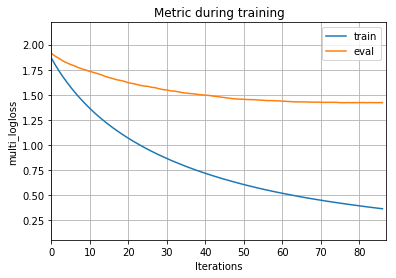

Plot feature importances...


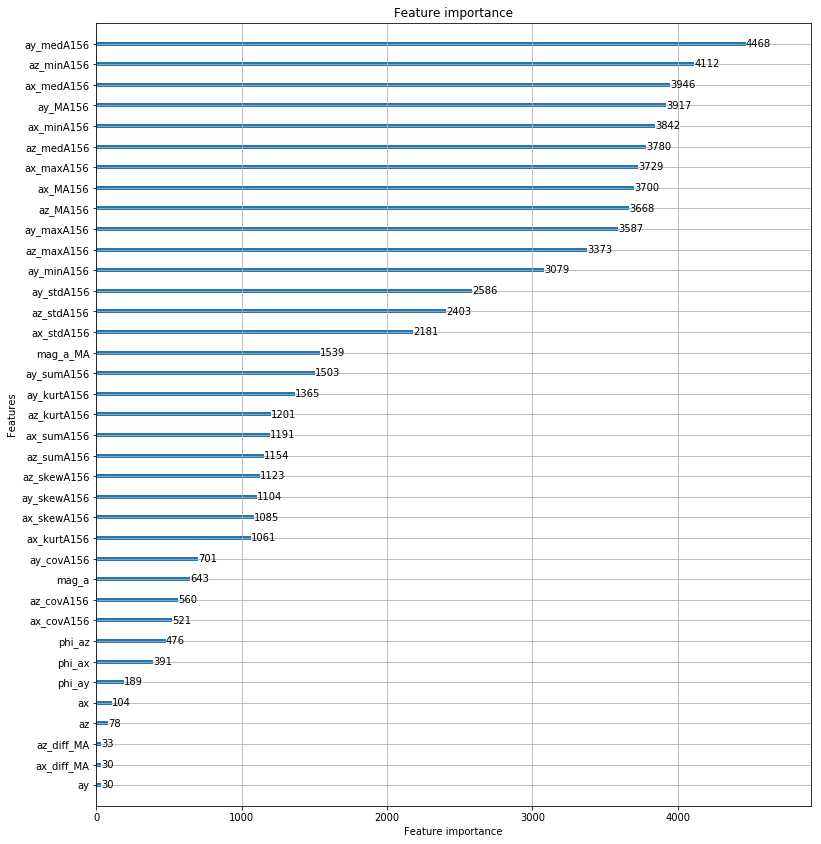

In [25]:
for iCV in range(kFold_num):
    
    print('\nCV :',iCV,'\n')
        
    print('Plot metrics recorded during training...')
    ax = lgb.plot_metric(evals_result[iCV], metric='multi_logloss')
    # if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
    plt.show()

    print('Plot feature importances...')
    ax = lgb.plot_importance(lgb_model[iCV], max_num_features=x_val[iCV].shape[1])
    ax.figure.set_size_inches(6.4*2,4.8*3)
    # if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
    plt.show()

In [26]:
y_test_pred={}
for iCV in range(kFold_num):
    y_test_pred[iCV] = lgb_model[iCV].predict(x_test)

In [27]:
y_test_pred_mean = y_test_pred[0]
for i in range(1,kFold_num): y_test_pred_mean =+ y_test_pred[i]
y_test_pred_mean = y_test_pred_mean / kFold_num

In [28]:
y_test_pred_argmax = np.argmax(y_test_pred_mean, axis=1)

In [29]:
#CONFUSION MATRIX

def draw_conf_mat(cnf_matrix):
    class_names = [class_dict[i] for i in range(1,8)]

    ax = sns.heatmap(cnf_matrix,annot=True,fmt="d")
    ax.figure.set_size_inches(11,8)
    ax.set_xticklabels(class_names,rotation='vertical')
    ax.set_yticklabels(class_names,rotation='horizontal')

def get_conf_matr(ytrue,ypred):
    crosstab = pd.crosstab(ytrue, ypred,
                              rownames=['True'], colnames=['Predicted'],
                              margins=True)
    crosstab = crosstab.reindex(index=[1,2,3,4,5,6,7,'All'], columns=[1,2,3,4,5,6,7,'All'], fill_value=0)
    return crosstab


def get_analytics(conf_mat):

    precision={}
    recall={}
    F1score={}

    print('\nPrecision :\n')
    for p in range(1,8): 
        if(conf_mat.loc['All',p]==0):
            precision[p]=0
        else:
            precision[p] = conf_mat.loc[p,p] / conf_mat.loc['All',p] 
        print('\t',p,': %.2f'%precision[p],'\t',class_dict[p])

    print('\nRecall :\n')
    for p in range(1,8): 
        if(conf_mat.loc[p,'All']==0):
            recall[p]=0
        else:
            recall[p] = conf_mat.loc[p,p] / conf_mat.loc[p,'All']
        print('\t',p,': %.2f'%recall[p],'\t',class_dict[p])

    print('\nF1 score :\n')
    for p in range(1,8): 
        if((precision[p] + recall[p])==0):
            F1score[p] =0
        else:
            F1score[p] = 2 * (precision[p] * recall[p]) / (precision[p] + recall[p])
        print('\t',p,': %.2f'%F1score[p],'\t',class_dict[p])

    tp_tot = 0
    for p in range(1,8): 
        tp_tot = tp_tot + conf_mat.loc[p,p] 
    acc = tp_tot / conf_mat.loc['All','All']
    
    print('\nAccuracy :\t%.2f'%acc)


Precision :

	 1 : 0.62 	 Working at Computer
	 2 : 0.26 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.33 	 Standing
	 4 : 0.85 	 Walking
	 5 : 0.86 	 Going Up/Down Stairs
	 6 : 0.55 	 Walking and Talking with Someone
	 7 : 0.82 	 Talking while Standing

Recall :

	 1 : 0.99 	 Working at Computer
	 2 : 0.05 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.51 	 Standing
	 4 : 0.95 	 Walking
	 5 : 0.22 	 Going Up/Down Stairs
	 6 : 0.32 	 Walking and Talking with Someone
	 7 : 0.42 	 Talking while Standing

F1 score :

	 1 : 0.76 	 Working at Computer
	 2 : 0.08 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.40 	 Standing
	 4 : 0.90 	 Walking
	 5 : 0.34 	 Going Up/Down Stairs
	 6 : 0.40 	 Walking and Talking with Someone
	 7 : 0.55 	 Talking while Standing

Accuracy :	0.65


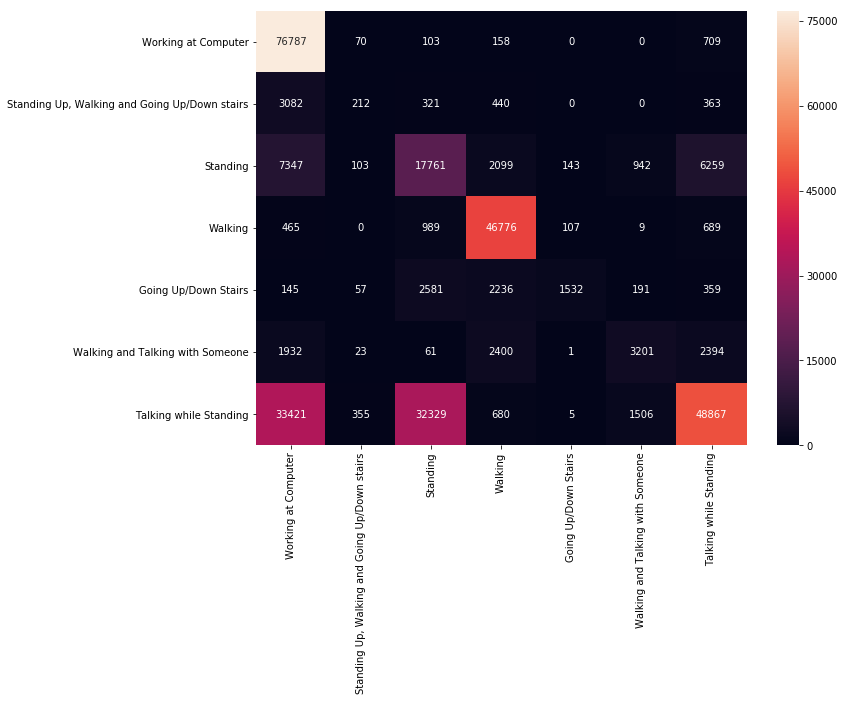

In [30]:
conf_mat = get_conf_matr(y_test.values, y_test_pred_argmax)
cnf_matrix = confusion_matrix(y_test.values, y_test_pred_argmax)
draw_conf_mat(cnf_matrix)
get_analytics(conf_mat)

Accuracy is 65% using boosted decision tree with adding many engineered features. Probably this can be much improved by acquiring domain knowledge to better create features.  

## Neural Network

This requires reshaping the data. Let's use window of 3 sec = 52 x 3 rows with 50% overlap.

In [31]:
# preprocess dataset for Time series Neural Net architecture

# WINDOW = 3 sec = 52 * 3 rows
# OVERLAP = 50%

def get_loop_param(dataset):
    window=52*3
    overlap=0.5
    length=dataset.shape[0]
    stride=int(window*overlap)
    num_loop=int(length / stride)
    skip= int(length % stride)
    print('len =',length,'num_loop =',num_loop,'window =',window,'stride =',stride,'skip =',skip,'check =', num_loop*stride + skip)
    
    return num_loop,window,stride,skip

def preprocess_into_3d_np(dataset):

    num_loop,window,stride,skip = get_loop_param(dataset)

    X = np.empty([num_loop,window,dataset.shape[1]-1])
    Y = np.empty([num_loop,1])
    
    datasetX = dataset.drop(columns=['label'])
    datasetY = dataset['label']

    for i in range(num_loop):
        for j in range(window):

            window_iloc = i*stride + j 
            if (i%250==0 and j==0): print(i,j,window_iloc)
            try:
                X[i][j] = datasetX.iloc[window_iloc].values
            except Exception as e:
                print('finished, or error occured:',e)
                break

        # get most frequent value of label in the window
        Y[i] = datasetY.iloc[i*stride : i*stride + window].value_counts().idxmax() 

    return X,Y

In [32]:
def save_preprocess_3d_np(person,save_folder):
    X_person={}
    Y_person={}

    os.system('mkdir -vp '+save_folder)
    for p in person:
        print('\nPerson',p,'\n')
        X_person[p],Y_person[p] = preprocess_into_3d_np(person[p])
        np.save(save_folder+'/X_person_{}'.format(p),X_person[p])
        np.save(save_folder+'/Y_person_{}'.format(p),Y_person[p])  

def get_preprocess_3d_np(save_folder):
    X_person={}
    Y_person={}

    print("\nLoad from folder:",save_folder,'\n')
    for p in person:
        X_person[p]=np.load(save_folder+'/X_person_{}.npy'.format(p))
        Y_person[p]=np.load(save_folder+'/Y_person_{}.npy'.format(p))  
        print('\tLoading Person',p,':',X_person[p].shape,Y_person[p].shape,'\n')

    return X_person,Y_person

In [33]:
# dropFeatures()
# save_preprocess_3d_np(person,'data_norm_3d_np')

Load pre-saved processed files with no features

In [34]:
X_person, Y_person = get_preprocess_3d_np('data_norm_3d_np')


Load from folder: data_norm_3d_np 

	Loading Person 1 : (2083, 156, 3) (2083, 1) 

	Loading Person 2 : (1765, 156, 3) (1765, 1) 

	Loading Person 3 : (1311, 156, 3) (1311, 1) 

	Loading Person 4 : (1566, 156, 3) (1566, 1) 

	Loading Person 5 : (2051, 156, 3) (2051, 1) 

	Loading Person 6 : (1803, 156, 3) (1803, 1) 

	Loading Person 7 : (2089, 156, 3) (2089, 1) 

	Loading Person 8 : (1766, 156, 3) (1766, 1) 

	Loading Person 9 : (2099, 156, 3) (2099, 1) 

	Loading Person 10 : (1625, 156, 3) (1625, 1) 

	Loading Person 11 : (1339, 156, 3) (1339, 1) 

	Loading Person 12 : (1470, 156, 3) (1470, 1) 

	Loading Person 13 : (867, 156, 3) (867, 1) 

	Loading Person 14 : (1488, 156, 3) (1488, 1) 

	Loading Person 15 : (1326, 156, 3) (1326, 1) 



In [35]:
# below are attempts to include engineered features. But this confuses the Network making it very to converge.
# X_ext_person, Y_ext_person = get_preprocess_3d_np('data_norm_3d_np_withFeatures')
# for p in person:
#     X_ext_person[p] = np.nan_to_num(X_ext_person[p])
#     Y_ext_person[p] = np.nan_to_num(Y_ext_person[p])
# X_person = X_ext_person
# Y_person = Y_ext_person

Using the person 13 as validation. Holding out person 1,2 for test set. The rest for training.

In [36]:
#train,val, test "split" for NN

train_list = [3,4,5,6,7,8,9,10,11,12,14,15]
val_list   = [13]
test_list  = [1,2]

#train
trainX = X_person[train_list[0]]
trainy = Y_person[train_list[0]]
for i in train_list[1:]:
    trainX = np.concatenate((trainX,X_person[i]))
    trainy =np.concatenate((trainy,Y_person[i]))
print(trainX.shape,trainy.shape)

#validation
valX = X_person[val_list[0]]
valy = Y_person[val_list[0]]
for i in val_list[1:]:
    valX = np.concatenate((valX,X_person[12]))
    valy = np.concatenate((valy,Y_person[12]))
print(valX.shape,valy.shape)

#test
testX = X_person[test_list[0]]
testy = Y_person[test_list[0]]
for i in test_list[1:]:
    testX = np.concatenate((testX,X_person[i]))
    testy = np.concatenate((testy,Y_person[i]))
print(testX.shape,testy.shape)


# zero-offset class values
trainy = trainy - 1
valy = valy - 1
testy = testy - 1

# one hot encode y
trainy = to_categorical(trainy,dtype='int')
valy = to_categorical(valy,dtype='int')
testy = to_categorical(testy,dtype='int')

(19933, 156, 3) (19933, 1)
(867, 156, 3) (867, 1)
(3848, 156, 3) (3848, 1)


In [37]:

def get_MODEL_CNN(model,n_timesteps, n_features):

    model.add(Conv1D(filters=48, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.01)))

    return model

def get_MODEL_LSTM(model,n_timesteps, n_features): 
    
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))

    return model

def get_MODEL_CNN_GRU(model,n_timesteps, n_features):

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(50))
    model.add(Dense(100, activation='relu'))

    return model

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, arch='CNN'):
    verbose, epochs, batch_size = 1, 10, 32
    #verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()

    if(arch=='CNN'):model = get_MODEL_CNN(model, n_timesteps, n_features)
    elif(arch=='LSTM'):model = get_MODEL_LSTM(model,n_timesteps, n_features)
    elif(arch=='CNN_GRU'):model = get_MODEL_CNN_GRU(model,n_timesteps, n_features)

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    # fit network
    history = model.fit(trainX, 
                        trainy, 
                        validation_data=(testX,testy),
                        #validation_split=0.2
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=verbose,
                        callbacks=[early_stop],
                       )
    
    # evaluate model
    _, accuracy = model.evaluate(testX, 
                                 testy, 
                                 batch_size=batch_size, 
                                 verbose=1)

    return history,accuracy,model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [38]:
history_cnn,score_cnn,model_cnn = evaluate_model(trainX, trainy, valX, valy,'CNN')

Train on 19933 samples, validate on 867 samples
Epoch 1/10
19933/19933 [==============================] - 15s 741us/step - loss: 1.6781 - acc: 0.6080 - val_loss: 1.4901 - val_acc: 0.6724
Epoch 2/10
19933/19933 [==============================] - 17s 839us/step - loss: 1.2151 - acc: 0.6654 - val_loss: 1.6135 - val_acc: 0.5029
Epoch 3/10
19933/19933 [==============================] - 14s 696us/step - loss: 1.1832 - acc: 0.6800 - val_loss: 1.5745 - val_acc: 0.4937
Epoch 00003: early stopping
867/867 [==============================] - 0s 116us/step


CNN Model is much faster than LSTM, CNN_GRU, with similar results. Will stick with 1D CNN model. See https://github.com/rsyarif/Activity_recognition/blob/master/Human_activity_recognition_v5.ipynb

In [39]:
#CNN - predictions

y_train_pred_cnn = model_cnn.predict(trainX)
y_val_pred_cnn = model_cnn.predict(valX)
y_test_pred_cnn = model_cnn.predict(testX)
print('CNN model score:',score_cnn)

y_train_pred_cnn_argmax = np.argmax(y_train_pred_cnn, axis=1)+1 #recover off set
y_val_pred_cnn_argmax = np.argmax(y_val_pred_cnn, axis=1)+1 #recover off set
y_test_pred_cnn_argmax = np.argmax(y_test_pred_cnn, axis=1)+1 #recover off set

print(y_train_pred_cnn_argmax.shape)
print(y_val_pred_cnn_argmax.shape)
print(y_test_pred_cnn_argmax.shape)


CNN model score: 0.49365628611257745
(19933,)
(867,)
(3848,)


In [40]:
#take highest probability as prediction and recover offset
y_train = np.argmax(trainy,axis=1)+1
y_val = np.argmax(valy,axis=1)+1
y_test = np.argmax(testy,axis=1)+1    

Train set

Precision :

	 1 : 0.79 	 Working at Computer
	 2 : 0.50 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.41 	 Standing
	 4 : 0.76 	 Walking
	 5 : 0.67 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.60 	 Talking while Standing

Recall :

	 1 : 0.78 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.02 	 Standing
	 4 : 0.91 	 Walking
	 5 : 0.00 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.91 	 Talking while Standing

F1 score :

	 1 : 0.78 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.03 	 Standing
	 4 : 0.83 	 Walking
	 5 : 0.01 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.72 	 Talking while Standing

Accuracy :	0.70


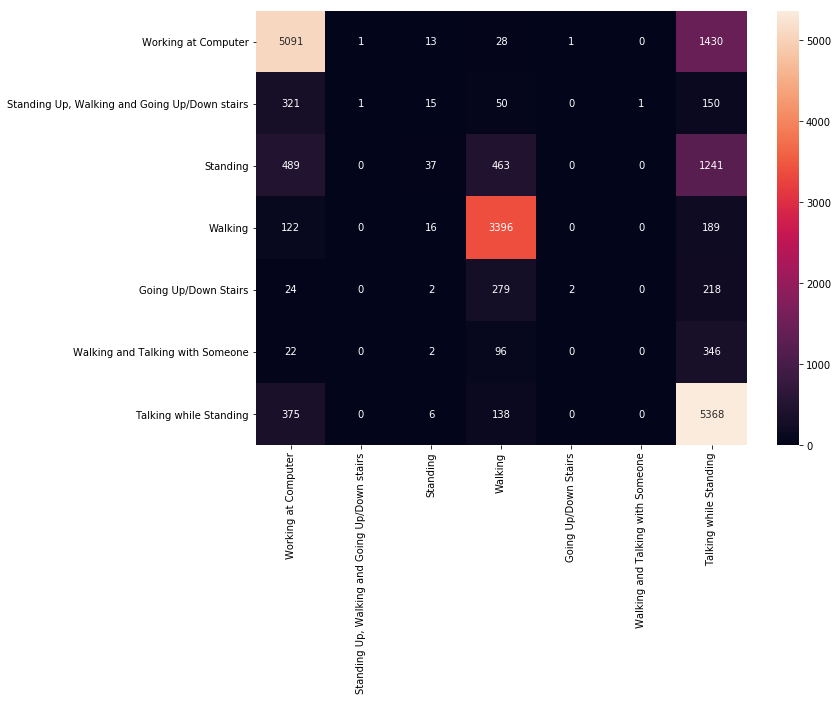

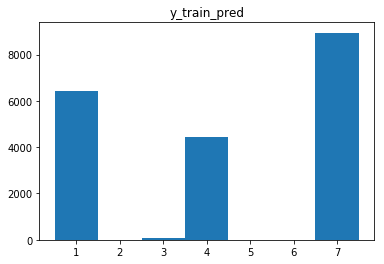

In [49]:
print("Train set")#. Model Accuracy:",history_cnn.history['acc'][-1])
conf_mat = get_conf_matr(y_train,y_train_pred_cnn_argmax)
get_analytics(conf_mat)
cnf_matrix_train = confusion_matrix(y_train, y_train_pred_cnn_argmax)
draw_conf_mat(cnf_matrix_train)
fig_train = plt.figure()
train_pred_hist = plt.hist(y_train_pred_cnn_argmax,bins=7,range=[0.5,7.5])
title_train = plt.title('y_train_pred')
# joint_train = sns.jointplot(x=y_train_pred_cnn_argmax,y=y_train,kind='hex').set_axis_labels("pred", "truth")
#conf_mat

Validation set

Precision :

	 1 : 0.46 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.50 	 Standing
	 4 : 0.73 	 Walking
	 5 : 0.00 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.35 	 Talking while Standing

Recall :

	 1 : 0.31 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.01 	 Standing
	 4 : 0.92 	 Walking
	 5 : 0.00 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.66 	 Talking while Standing

F1 score :

	 1 : 0.37 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.02 	 Standing
	 4 : 0.81 	 Walking
	 5 : 0.00 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.45 	 Talking while Standing

Accuracy :	0.49


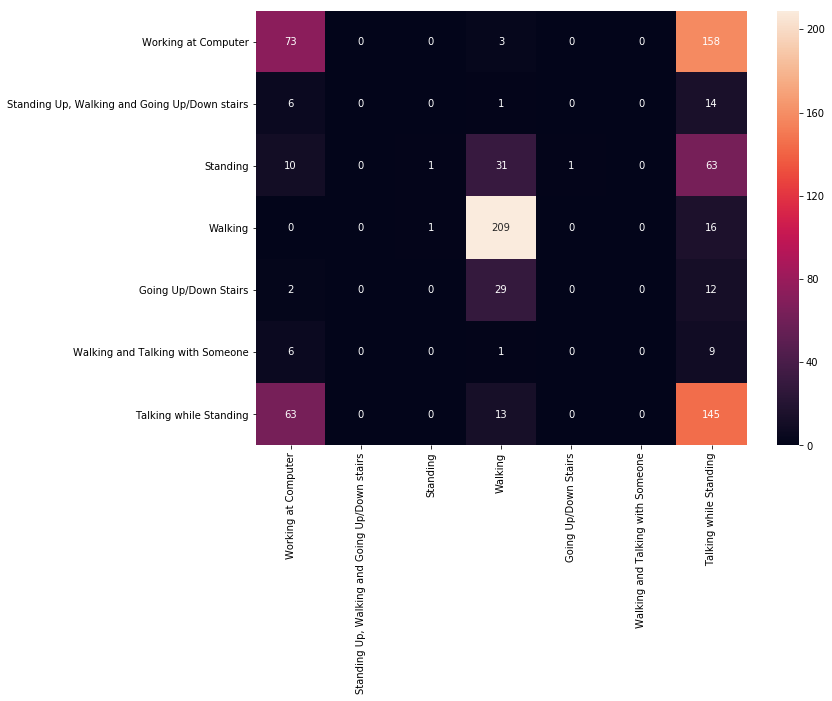

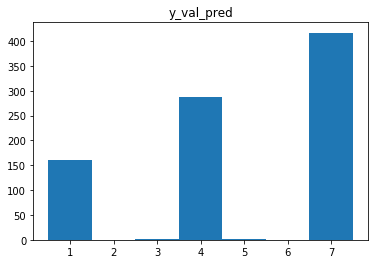

In [50]:
print("Validation set")#. Model Accuracy:",history_cnn.history['val_acc'][-1])
conf_mat = get_conf_matr(y_val,y_val_pred_cnn_argmax)
cnf_matrix_val = confusion_matrix(y_val, y_val_pred_cnn_argmax)
get_analytics(conf_mat)
draw_conf_mat(cnf_matrix_val)
fig_val = plt.figure()
val_pred_hist = plt.hist(y_val_pred_cnn_argmax,bins=7,range=[0.5,7.5])
title_val = plt.title('y_val_pred')
# joint_val = sns.jointplot(x=y_val_pred_cnn_argmax,y=y_val,kind='hex').set_axis_labels("pred", "truth")
#conf_mat

Test set

Precision :

	 1 : 0.64 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.47 	 Standing
	 4 : 0.77 	 Walking
	 5 : 1.00 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.75 	 Talking while Standing

Recall :

	 1 : 0.96 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.02 	 Standing
	 4 : 0.93 	 Walking
	 5 : 0.01 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.79 	 Talking while Standing

F1 score :

	 1 : 0.76 	 Working at Computer
	 2 : 0.00 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.03 	 Standing
	 4 : 0.84 	 Walking
	 5 : 0.02 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.77 	 Talking while Standing

Accuracy :	0.71


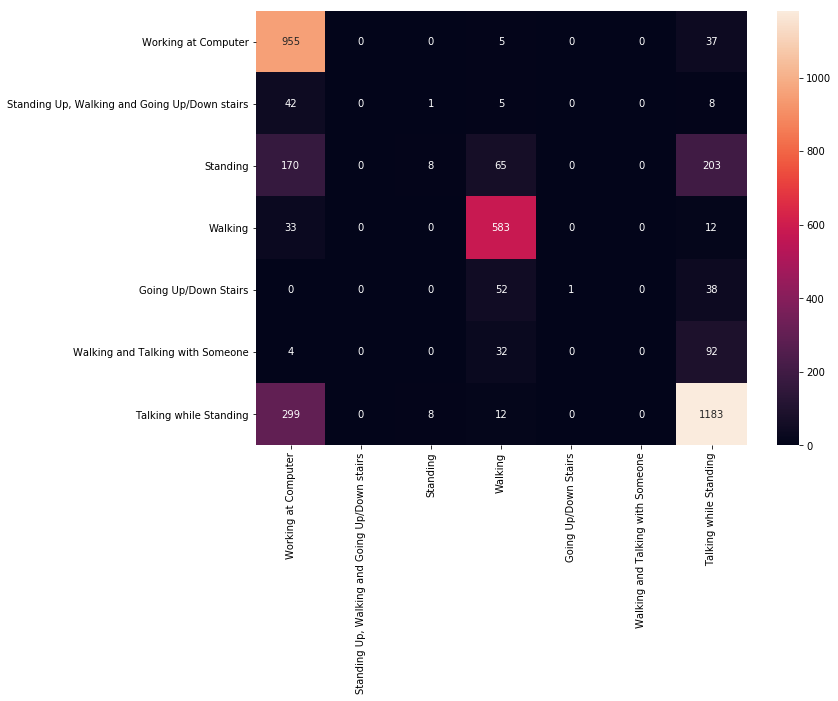

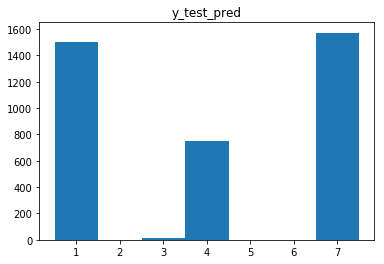

In [51]:
print("Test set")
conf_mat = get_conf_matr(y_test,y_test_pred_cnn_argmax)
get_analytics(conf_mat)
cnf_matrix_test = confusion_matrix(y_test, y_test_pred_cnn_argmax)
draw_conf_mat(cnf_matrix_test)
fig_test = plt.figure()
test_pred_hist = plt.hist(y_test_pred_cnn_argmax,bins=7,range=[0.5,7.5])
title_test = plt.title('y_test_pred')
#joint_test = sns.jointplot(x=y_test_pred_cnn_argmax,y=y_test,kind='hex').set_axis_labels("pred", "truth")
#conf_mat

With the current setup, Conv1D NN is able to achieve ~70% accuracy (with only 3 features). 

Initially, training up to ~90% accuracy with the training model was achieved. However the validation set accuracy was indicating overfitting. Regularization was performed by adding L2 regularizer and Dropout layers, resulting in a reduced training set accuracy but increased validation and test set accuracy.

Model could be much improved by acquiring more train set with labels 2,3,5,6 which are clearly lacking the current train set in order to increase precision, recall, F1 on each of these activities which would overall increase the accuracy.

Regarding noise, currently no filtering nor calibration have been applied. A quick survey of articles/literatures on accelerometer data indicate that a low pass filter and calibration preprocessing are highly effective in filtering out the noise. This will likely make the model fit much better. This is certainly the thing to be done in an extended project.